Taining the model

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
class MalariaDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for idx, cls in enumerate(classes):
            img_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(img_path):
                self.image_paths.append(os.path.join(img_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


Dataset and Loaders

In [5]:
root_dir = "../data/raw"   # adjust path if needed
classes = ["Parasitized", "Uninfected"]

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

malaria_dataset = MalariaDataset(root_dir=root_dir, classes=classes, transform=transform)

train_size = int(0.8 * len(malaria_dataset))
test_size = len(malaria_dataset) - train_size
train_dataset, test_dataset = random_split(malaria_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 22046
Test samples: 5512


In [6]:
class MalariaCNN(nn.Module):
    
    def __init__(self):
        super(MalariaCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(), # activation function, helps model learn complex patterns
            nn.MaxPool2d(kernel_size=2, stride=2), # downsample feature maps, why: reduce spatial dimensions, control overfitting

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier 
        self.classifier = nn.Sequential(
            nn.Flatten(), # flatten feature maps to 1D vector
            nn.Linear(in_features=64 * 18 * 18, out_features=128), # assuming input images are 150x150
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2) # binary classification
        )
        
    # Define forward pass
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
model = MalariaCNN().to(device)
model

MalariaCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=20736, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

Create Loss ans Optimizer

In [7]:
criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

Training Loop

In [8]:
epoches = 3
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(epoches):
    model.train() # set model to training mode
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader: # iterate over training batches
        images, labels = images.to(device), labels.to(device) # move images and labels(0 or 1) to device
        
        optimizer.zero_grad() # To clear previous gradients
        outputs = model(images) # forward pass i.e predicted outputs
        
        loss = criterion(outputs, labels) # compute lossi.e. difference between predicted and actual labels
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1) # get class with highest probability i.e. predicted class which is 0 or 1
        total += labels.size(0) # total number of labels in the batch to calculate accuracy
        correct += (predicted == labels).sum().item() # count correct predictions
        
    epoch_loss = running_loss / len(train_loader.dataset) # average loss for the epoch
    epoch_acc = correct / total # accuracy for the epoch
    train_losses.append(epoch_loss) # store training loss for each epoch
    train_accuracies.append(epoch_acc) # store training accuracy for each epoch
    
    print(f'Epoch [{epoch+1}/{epoches}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}')

Epoch [1/3], Training Loss: 0.2549, Training Accuracy: 0.8939
Epoch [2/3], Training Loss: 0.1443, Training Accuracy: 0.9538
Epoch [3/3], Training Loss: 0.1272, Training Accuracy: 0.9579


Quantized model saved as 'malaria_cnn_quantized_model.pt'
Final Test Accuracy (Quantized + TorchScript): 0.9563


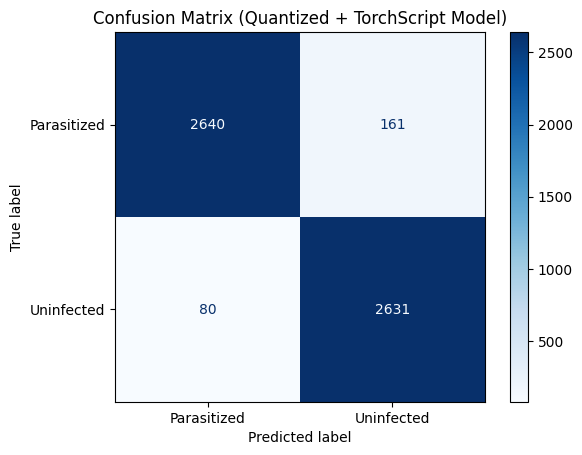

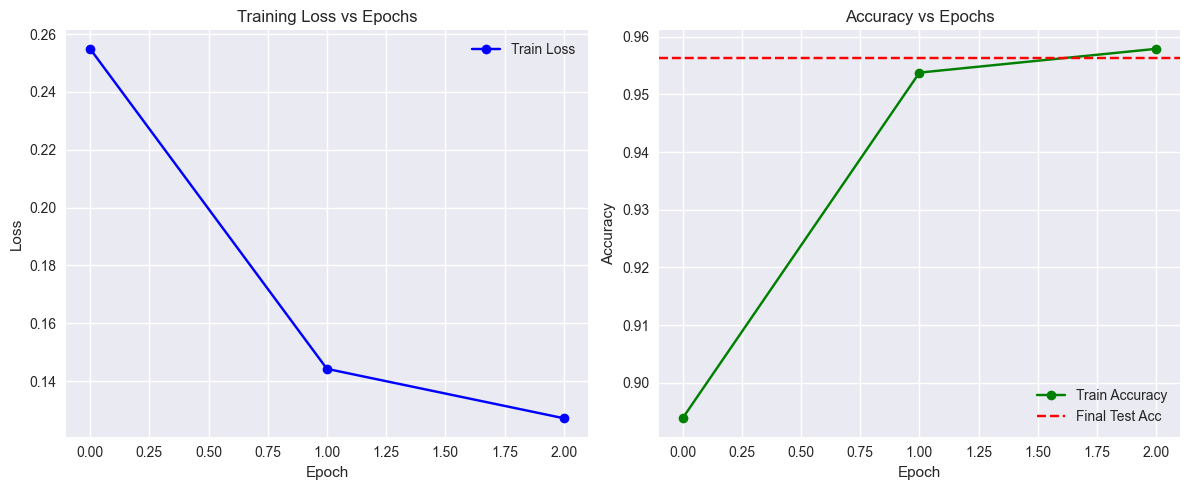

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Model Quantization ---
model.eval()  # original trained model

quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Convert to TorchScript
scripted_model = torch.jit.script(quantized_model)
scripted_model.save("malaria_cnn_quantized_model.pt")
print("Quantized model saved as 'malaria_cnn_quantized_model.pt'")

# --- Load Quantized TorchScript Model ---
loaded_model = torch.jit.load("malaria_cnn_quantized_model.pt")
loaded_model.to(device)
loaded_model.eval()

# --- Evaluation ---
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)   
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f"Final Test Accuracy (Quantized + TorchScript): {test_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Quantized + TorchScript Model)")
plt.show()

# --- Training Curves ---
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
ax1.plot(train_losses, marker='o', color='blue', label='Train Loss')
ax1.set_title('Training Loss vs Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curve
ax2.plot(train_accuracies, marker='o', color='green', label='Train Accuracy')
#ax2.plot(val_accuracies, marker='s', color='orange', label='Validation Accuracy')
ax2.axhline(y=test_acc, color='red', linestyle='--', label='Final Test Acc')
ax2.set_title('Accuracy vs Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [10]:
print(os.path.getsize("malaria_cnn_quantized_model.pt"))

2773211
